In [68]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import MDAnalysis.transformations as trans
import nglview as nv
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.integrate import cumulative_trapezoid

In [69]:
top = 'prd.tpr'
trj = 'prd.xtc'

u = mda.Universe(top, trj)

In [70]:
u.trajectory[0]

segids = ['seg_0_PROA', 'seg_1_PROB', 'seg_2_PROC']  # 3 monomers

# OmpC
A_resids = [105, 109]  # acidic residues (ASP105, GLU109)
B_resids = [16, 37, 74, 124]  # basic residues (LYS16, ARG37, ARG74, ARG124)

# OmpF (uncomment to switch)
# A_resids = [117, 113]  # acidic residues (ASP117, GLU113)
# B_resids = [16, 42, 82, 132]  # basic residues (LYS16, ARG42, ARG82, ARG132)

# ---------- Pre-select atom groups once per monomer ----------

A_CA_groups = []
B_CA_groups = []

for segid in segids:
    seg_protein = u.select_atoms(f"segid {segid} and protein")
    # use resid selection directly; MDAnalysis keeps these dynamic across frames
    A_res = seg_protein.residues[[i-1 for i in A_resids]]
    B_res = seg_protein.residues[[i-1 for i in B_resids]]
    A_CA = A_res.atoms.select_atoms("name CA")
    B_CA = B_res.atoms.select_atoms("name CA")
    A_CA_groups.append(A_CA)
    B_CA_groups.append(B_CA)

n_seg = len(segids)

# Running sums for centers and directions
sum_pore_centers = np.zeros((n_seg, 3), dtype=float)
sum_cr_vectors   = np.zeros((n_seg, 3), dtype=float)
n_frames = 0

# ---------- Loop over trajectory ONCE ----------

for ts in tqdm(u.trajectory):
    for i in range(n_seg):
        A_CA = A_CA_groups[i]
        B_CA = B_CA_groups[i]

        A_com = A_CA.center_of_mass()
        B_com = B_CA.center_of_mass()

        cr_vector = A_com - B_com
        cr_vector[2] = 0.0  # project into xy-plane
        cr_norm = np.linalg.norm(cr_vector)
        if cr_norm > 0:
            cr_vector /= cr_norm

        pore_center = (A_com + B_com) / 2.0

        sum_pore_centers[i] += pore_center
        sum_cr_vectors[i]   += cr_vector

    n_frames += 1

# ---------- Average over frames ----------

pore_centers = sum_pore_centers / n_frames
cr_directions = sum_cr_vectors

# Normalize cr_directions for each monomer
cr_directions = cr_directions / np.linalg.norm(cr_directions, axis=1, keepdims=True)

# define y direction as cr_directions
y_directions = cr_directions

# x direction is perpendicular to y direction in xy-plane
x_directions = np.stack(
    [-y_directions[:, 1], y_directions[:, 0], np.zeros(n_seg)],
    axis=1
)
x_directions = x_directions / np.linalg.norm(x_directions, axis=1, keepdims=True)

# z direction from cross product
z_directions = np.cross(x_directions, y_directions)
z_directions = z_directions / np.linalg.norm(z_directions, axis=1, keepdims=True)


100%|██████████| 374/374 [00:00<00:00, 498.95it/s]


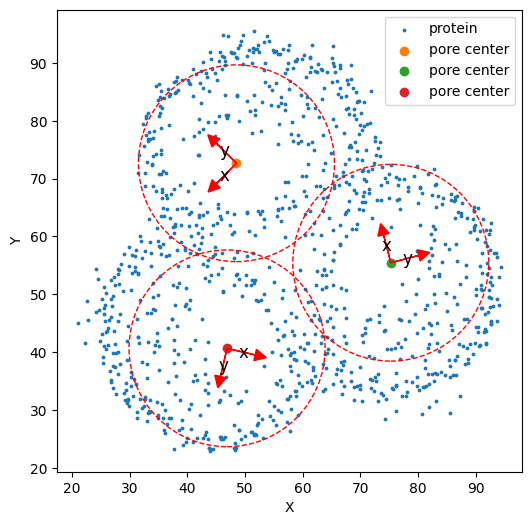

In [71]:
# visualize pore centers and cr directions
u.trajectory[0]

protein = u.select_atoms('protein and name CA').positions
waters = u.select_atoms('resname TIP3').positions

plt.figure(figsize=(6,6))
plt.scatter(protein[:,0], protein[:,1], s=3, label='protein')
plt.scatter(pore_centers[0][0], pore_centers[0][1], label='pore center')
plt.scatter(pore_centers[1][0], pore_centers[1][1], label='pore center')
plt.scatter(pore_centers[2][0], pore_centers[2][1], label='pore center')
# draw a circle that center at pore_center with radius 
plt.gca().add_patch(plt.Circle(pore_centers[0], 17, fill=False, color='r', linestyle='--'))
plt.gca().add_patch(plt.Circle(pore_centers[1], 17, fill=False, color='r', linestyle='--'))
plt.gca().add_patch(plt.Circle(pore_centers[2], 17, fill=False, color='r', linestyle='--'))
# draw cr_vector with arrows
for i in range(3):
    plt.arrow(pore_centers[i][0], pore_centers[i][1], y_directions[i][0]*5, y_directions[i][1]*5,
              head_width=2, head_length=2, fc='r', ec='r')
    plt.text(pore_centers[i][0] + y_directions[i][0]*3, pore_centers[i][1] + y_directions[i][1]*3, 'y', fontsize=12, ha='center', va='center')
    plt.arrow(pore_centers[i][0], pore_centers[i][1], x_directions[i][0]*5, x_directions[i][1]*5,
              head_width=2, head_length=2, fc='r', ec='r')
    plt.text(pore_centers[i][0] + x_directions[i][0]*3, pore_centers[i][1] + x_directions[i][1]*3, 'x', fontsize=12, ha='center', va='center')

plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [72]:
# distribution of water molecules in the cylindrical region
u.trajectory[0]

# setting: the selected water molecules are in the cylindrical region centered at each pore_center
cylinder_radius = 17.0
cylinder_radius2 = cylinder_radius**2
cylinder_height = 70.0
half_height = cylinder_height / 2.0

# waters_in_cyls[monomer][frame] -> positions of water atoms inside that monomer's cylinder
waters_in_cyls = [[] for _ in range(len(segids))]

# Preselect all TIP3 waters once
waters = u.select_atoms('resname TIP3')   # all water atoms
n_waters = waters.n_atoms // 3           # number of water molecules

for ts in tqdm(u.trajectory):
    # Update coordinates for this frame
    pos_all = waters.positions           # shape (3*N_waters, 3)
    
    # Oxygen atoms are every third atom: [0, 3, 6, ...]
    O_pos = pos_all[::3]                 # shape (N_waters, 3)

    # For each monomer, find which waters are in its cylinder
    for i, pore_center in enumerate(pore_centers):
        r = O_pos - pore_center          # vector from pore center to O

        # Cylinder condition: |z| < half_height and x^2 + y^2 < R^2
        mask_O = (
            (np.abs(r[:, 2]) < half_height) &
            ((r[:, 0]**2 + r[:, 1]**2) < cylinder_radius2)
        )

        if not np.any(mask_O):
            # No water in this monomer's cylinder for this frame
            waters_in_cyls[i].append(np.empty((0, 3), dtype=float))
            continue

        # Expand O-mask (length N_waters) to all atoms (length 3*N_waters)
        # because atoms are ordered [O, H1, H2, O, H1, H2, ...]
        full_mask = np.repeat(mask_O, 3)

        # Store positions of all water atoms in the cylinder for this monomer/frame
        waters_in_cyls[i].append(pos_all[full_mask])


100%|██████████| 374/374 [00:01<00:00, 310.83it/s]


In [73]:
# setting : each cylinder is divided into slices with thickness dz. A spherical probe is placed in the average of oxygen atoms of each slice
dz = 0.5
probe_radius = 7.0
probe_radius2 = probe_radius**2
v_w = 29.9  # volume of water molecule
mu = 2.35   # dipole moment of water molecule
P_all = []  # array of shape (monomer, frame, slice, dimension)

for i, segid in enumerate(segids):
    pore_center = pore_centers[i]
    z_min = pore_center[2] - half_height
    z_max = pore_center[2] + half_height
    x_direction = x_directions[i]
    y_direction = y_directions[i]
    z_direction = z_directions[i]

    # Precompute z grid for slices (centers)
    z_centers = np.arange(z_min, z_max, dz)
    n_slices = len(z_centers)

    P_seg = []
    for frame_idx, waters in enumerate(waters_in_cyls[i]):

        # If no waters in this frame inside cylinder, just fill zeros
        if waters.size == 0:
            P_seg.append(np.zeros((n_slices, 3), dtype=float))
            continue

        # Split into O, H1, H2 once per frame
        O_all  = waters[::3]   # shape (Nw, 3)
        H1_all = waters[1::3]
        H2_all = waters[2::3]

        # -------- 1) Compute probe centers per slice (using z-binning) --------
        zO = O_all[:, 2]

        # Map each O to a slice index
        slice_idx = ((zO - z_min) / dz).astype(int)
        valid = (slice_idx >= 0) & (slice_idx < n_slices)
        slice_idx = slice_idx[valid]
        O_valid = O_all[valid]

        # If none are valid, just use pore_center along slices
        if slice_idx.size == 0:
            probe_centers = np.tile(pore_center, (n_slices, 1))
            probe_centers[:, 2] = z_centers  # align z with slice centers
        else:
            # Compute sums per slice using bincount
            counts = np.bincount(slice_idx, minlength=n_slices)

            sum_x = np.bincount(slice_idx, weights=O_valid[:, 0], minlength=n_slices)
            sum_y = np.bincount(slice_idx, weights=O_valid[:, 1], minlength=n_slices)
            sum_z = np.bincount(slice_idx, weights=O_valid[:, 2], minlength=n_slices)

            probe_centers = np.empty((n_slices, 3), dtype=float)

            # Where we have water in the slice: mean position
            nonzero = counts > 0
            probe_centers[nonzero, 0] = sum_x[nonzero] / counts[nonzero]
            probe_centers[nonzero, 1] = sum_y[nonzero] / counts[nonzero]
            probe_centers[nonzero, 2] = sum_z[nonzero] / counts[nonzero]

            # Where slice is empty: propagate previous center (your original logic)
            # with z set to the slice center
            for s in range(n_slices):
                if not nonzero[s]:
                    if s == 0:
                        # first slice empty: start from pore_center
                        probe_centers[s, :] = pore_center
                        probe_centers[s, 2] = z_centers[s]
                    else:
                        probe_centers[s, :] = probe_centers[s - 1]
                        probe_centers[s, 2] = z_centers[s]

        # -------- 2) Compute polarization per spherical probe --------
        P_frame = np.zeros((n_slices, 3), dtype=float)

        # Precompute dipole direction parts (vector from O to H1/H2 mid)
        vec = (H1_all + H2_all) / 2.0 - O_all   # (Nw, 3)
        norms = np.linalg.norm(vec, axis=1, keepdims=True)
        norms[norms == 0] = 1.0
        unit_vec = vec / norms                  # (Nw, 3), direction of dipole

        for s in range(n_slices):
            center = probe_centers[s]

            # squared distances from this probe center
            diff = O_all - center
            dist2 = np.einsum('ij,ij->i', diff, diff)
            mask = dist2 < probe_radius2

            num_O = np.count_nonzero(mask)
            if num_O == 0:
                continue  # P_frame[s] stays zero

            # dipoles of waters in the probe
            dipoles = unit_vec[mask] * mu           # (Ns, 3)
            P_vec = dipoles.sum(axis=0) / num_O / v_w

            # Project onto local xyz directions
            P_frame[s, 0] = np.dot(P_vec, x_direction)
            P_frame[s, 1] = np.dot(P_vec, y_direction)
            P_frame[s, 2] = np.dot(P_vec, z_direction)

        P_seg.append(P_frame)

    P_seg = np.array(P_seg)   # (n_frames, n_slices, 3)
    P_all.append(P_seg)

P_all = np.array(P_all)       # (n_monomers, n_frames, n_slices, 3)


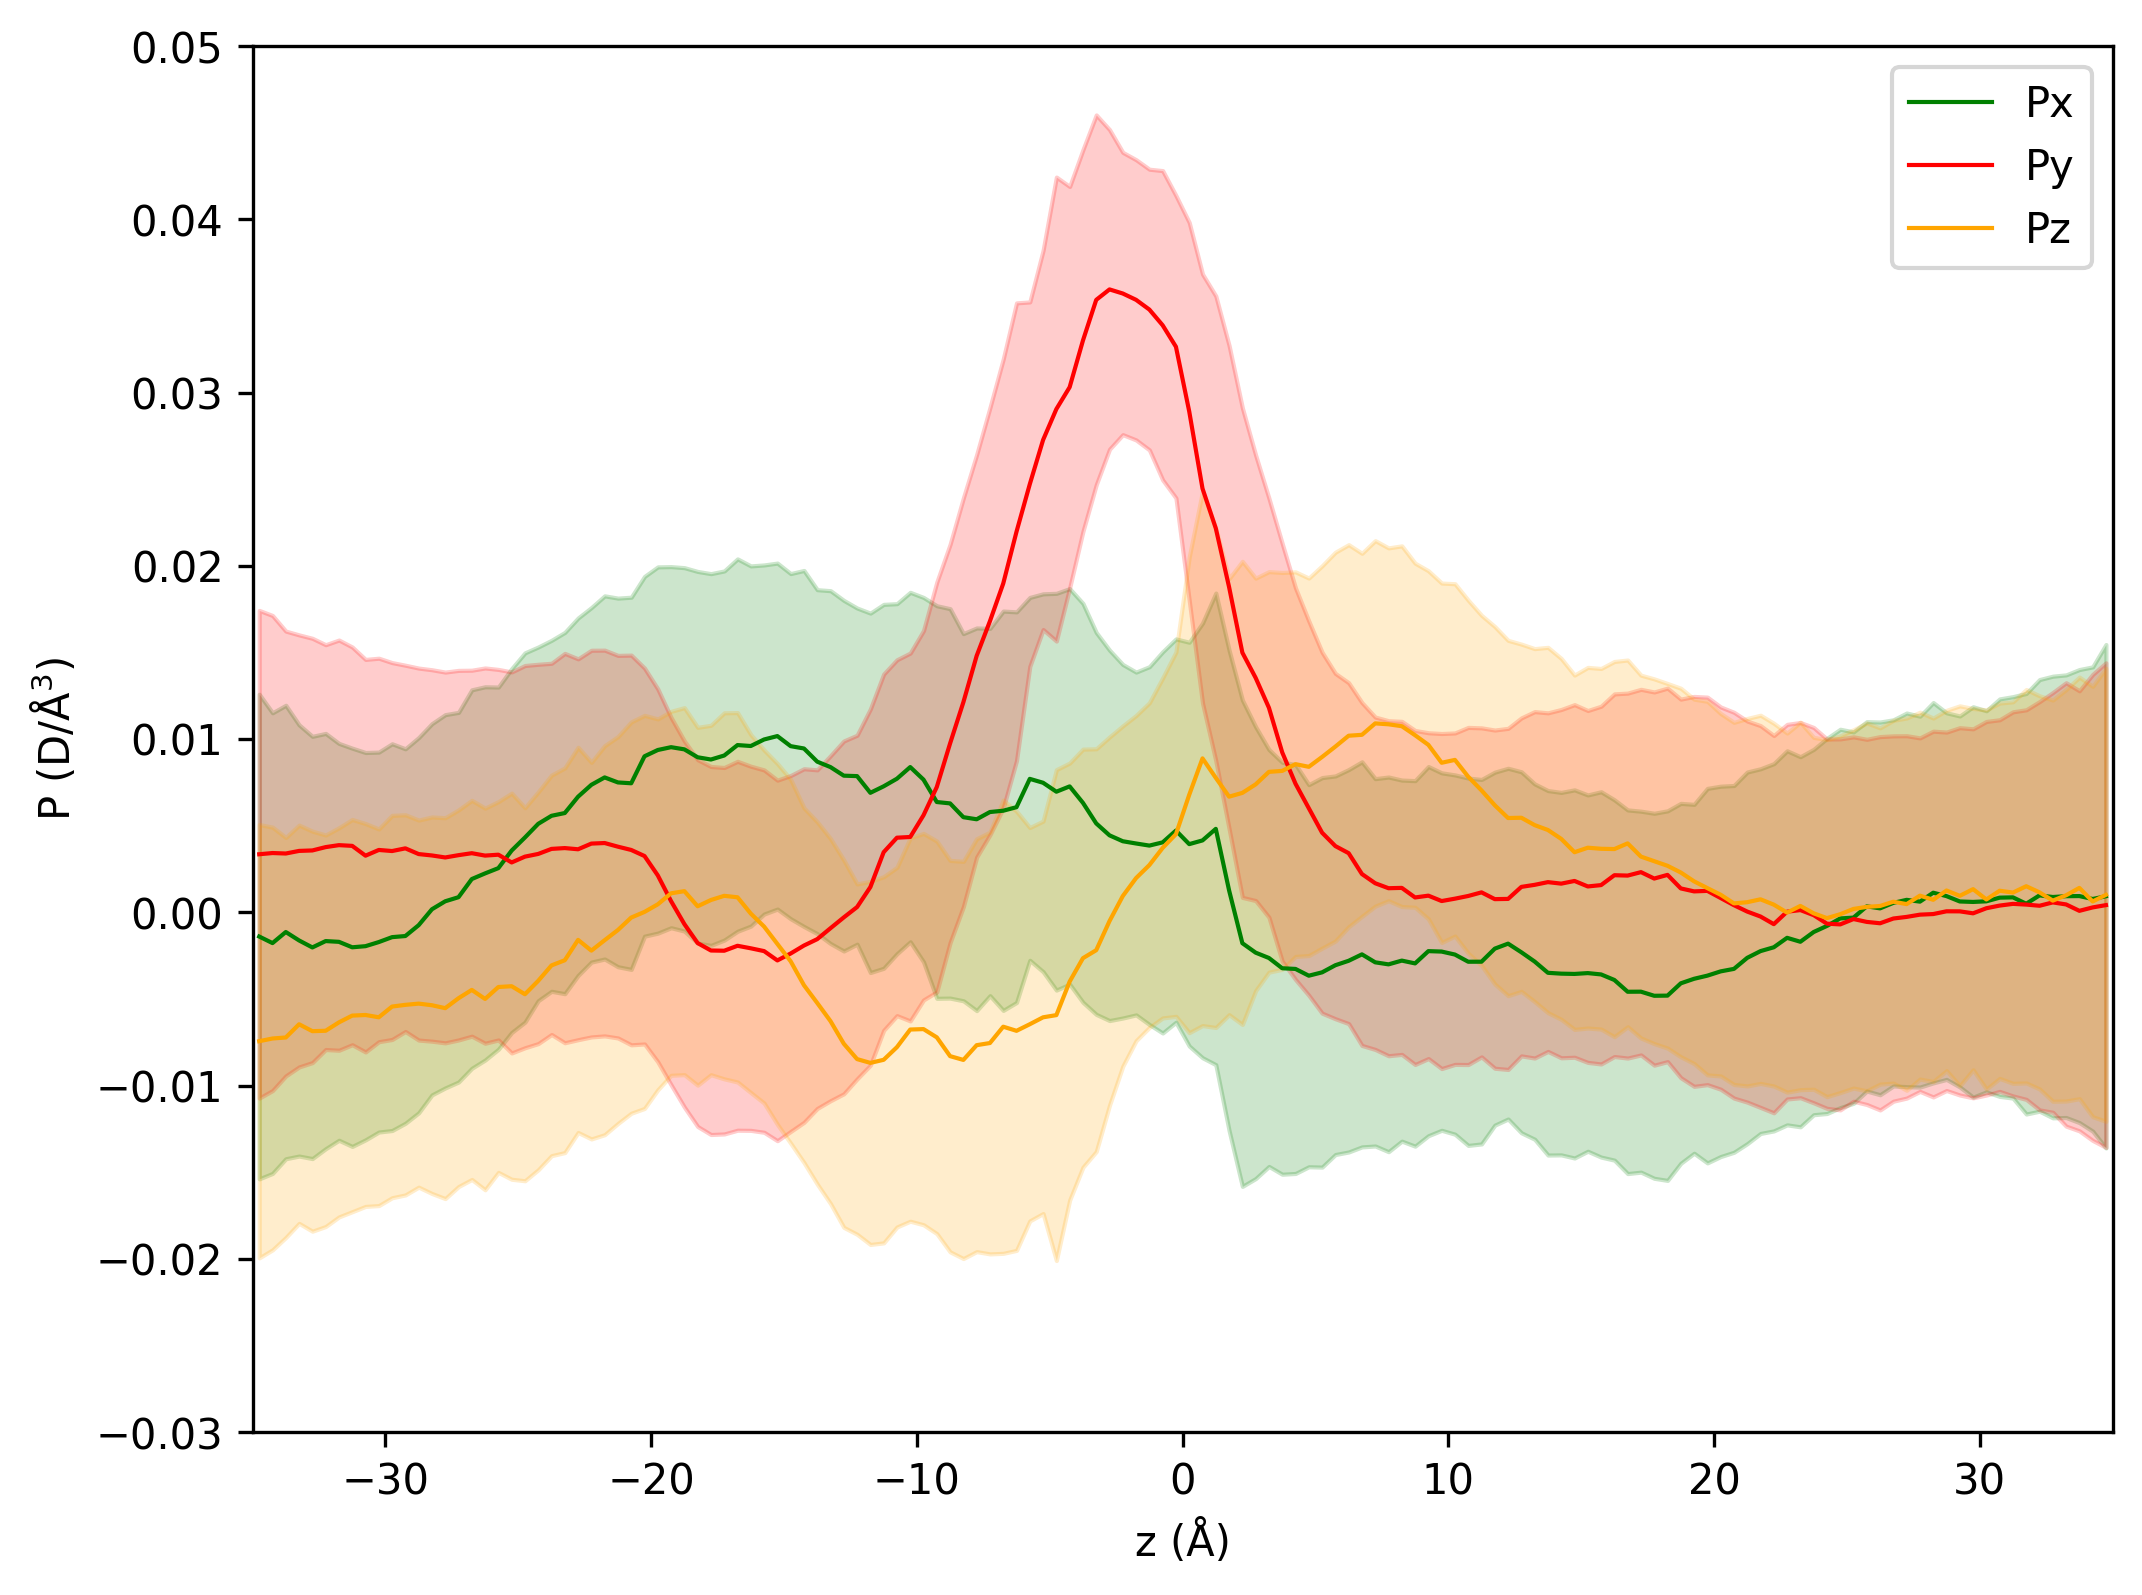

In [74]:
P_mean = np.mean(P_all, axis=(0, 1)) # array of shape (slab, dimension)
P_std = np.std(P_all, axis=(0, 1)) # array of shape (slab, dimension)

z = np.arange(z_min, z_max, dz) - np.mean(np.arange(z_min, z_max, dz))
plt.figure(figsize=(8,6), dpi=300)
plt.plot(z, P_mean[:, 0], label='Px', color='g', linewidth=1)
plt.fill_between(z, P_mean[:, 0] - P_std[:, 0], P_mean[:, 0] + P_std[:, 0], alpha=0.2, color='g')
plt.plot(z, P_mean[:, 1], label='Py', color='r', linewidth=1)
plt.fill_between(z, P_mean[:, 1] - P_std[:, 1], P_mean[:, 1] + P_std[:, 1], alpha=0.2, color='r')
plt.plot(z, P_mean[:, 2], label='Pz', color='orange', linewidth=1)
plt.fill_between(z, P_mean[:, 2] - P_std[:, 2], P_mean[:, 2] + P_std[:, 2], alpha=0.2, color='orange')
plt.ylim(-0.03, 0.05)
plt.xlim(-35, 35)
plt.xlabel('z (Å)')
plt.ylabel('P (D/Å$^3$)')
plt.legend()
plt.show()

In [75]:
def Langevin(x):
    x = x + 1e-10 # avoid division by zero
    return 1 / np.tanh(x) - 1/x

def Booth(E, a=0.00001, b=0.07, c=0.0907651):
    """
    Booth polarization for a *magnitude* of E.
    E can be scalar or array (we only care about |E| in this model).
    """
    E = np.asarray(E, dtype=float)
    E_abs = np.abs(E)
    return a * E_abs + b * Langevin(E_abs * c)

def invert_Booth(P_target, E_min=0.0, E_max=500.0):
    """
    Invert Booth: given P (which may be positive or negative),
    return E with the *same sign* as P. Magnitudes are related
    by Booth(|E|) = |P|.
    """
    P_target = float(P_target)
    sign = np.sign(P_target) if P_target != 0.0 else 0.0
    P_abs = abs(P_target)

    if P_abs < 1e-8:
        return 0.0

    def f(E):
        # E is taken as a magnitude here
        return Booth(E) - P_abs

    try:
        E_abs = brentq(f, E_min, E_max)
    except ValueError:
        # No sign change in [E_min, E_max] (e.g., saturation) → clip
        E_abs = E_max

    return sign * E_abs

# E = np.linspace(0.1, 500, 100)
# P = Booth(E)
# plt.xticks(np.arange(0, 501, 50))
# plt.ylim(0, 0.08)
# plt.xlim(0, 500)
# plt.plot(E, P)
# plt.show()

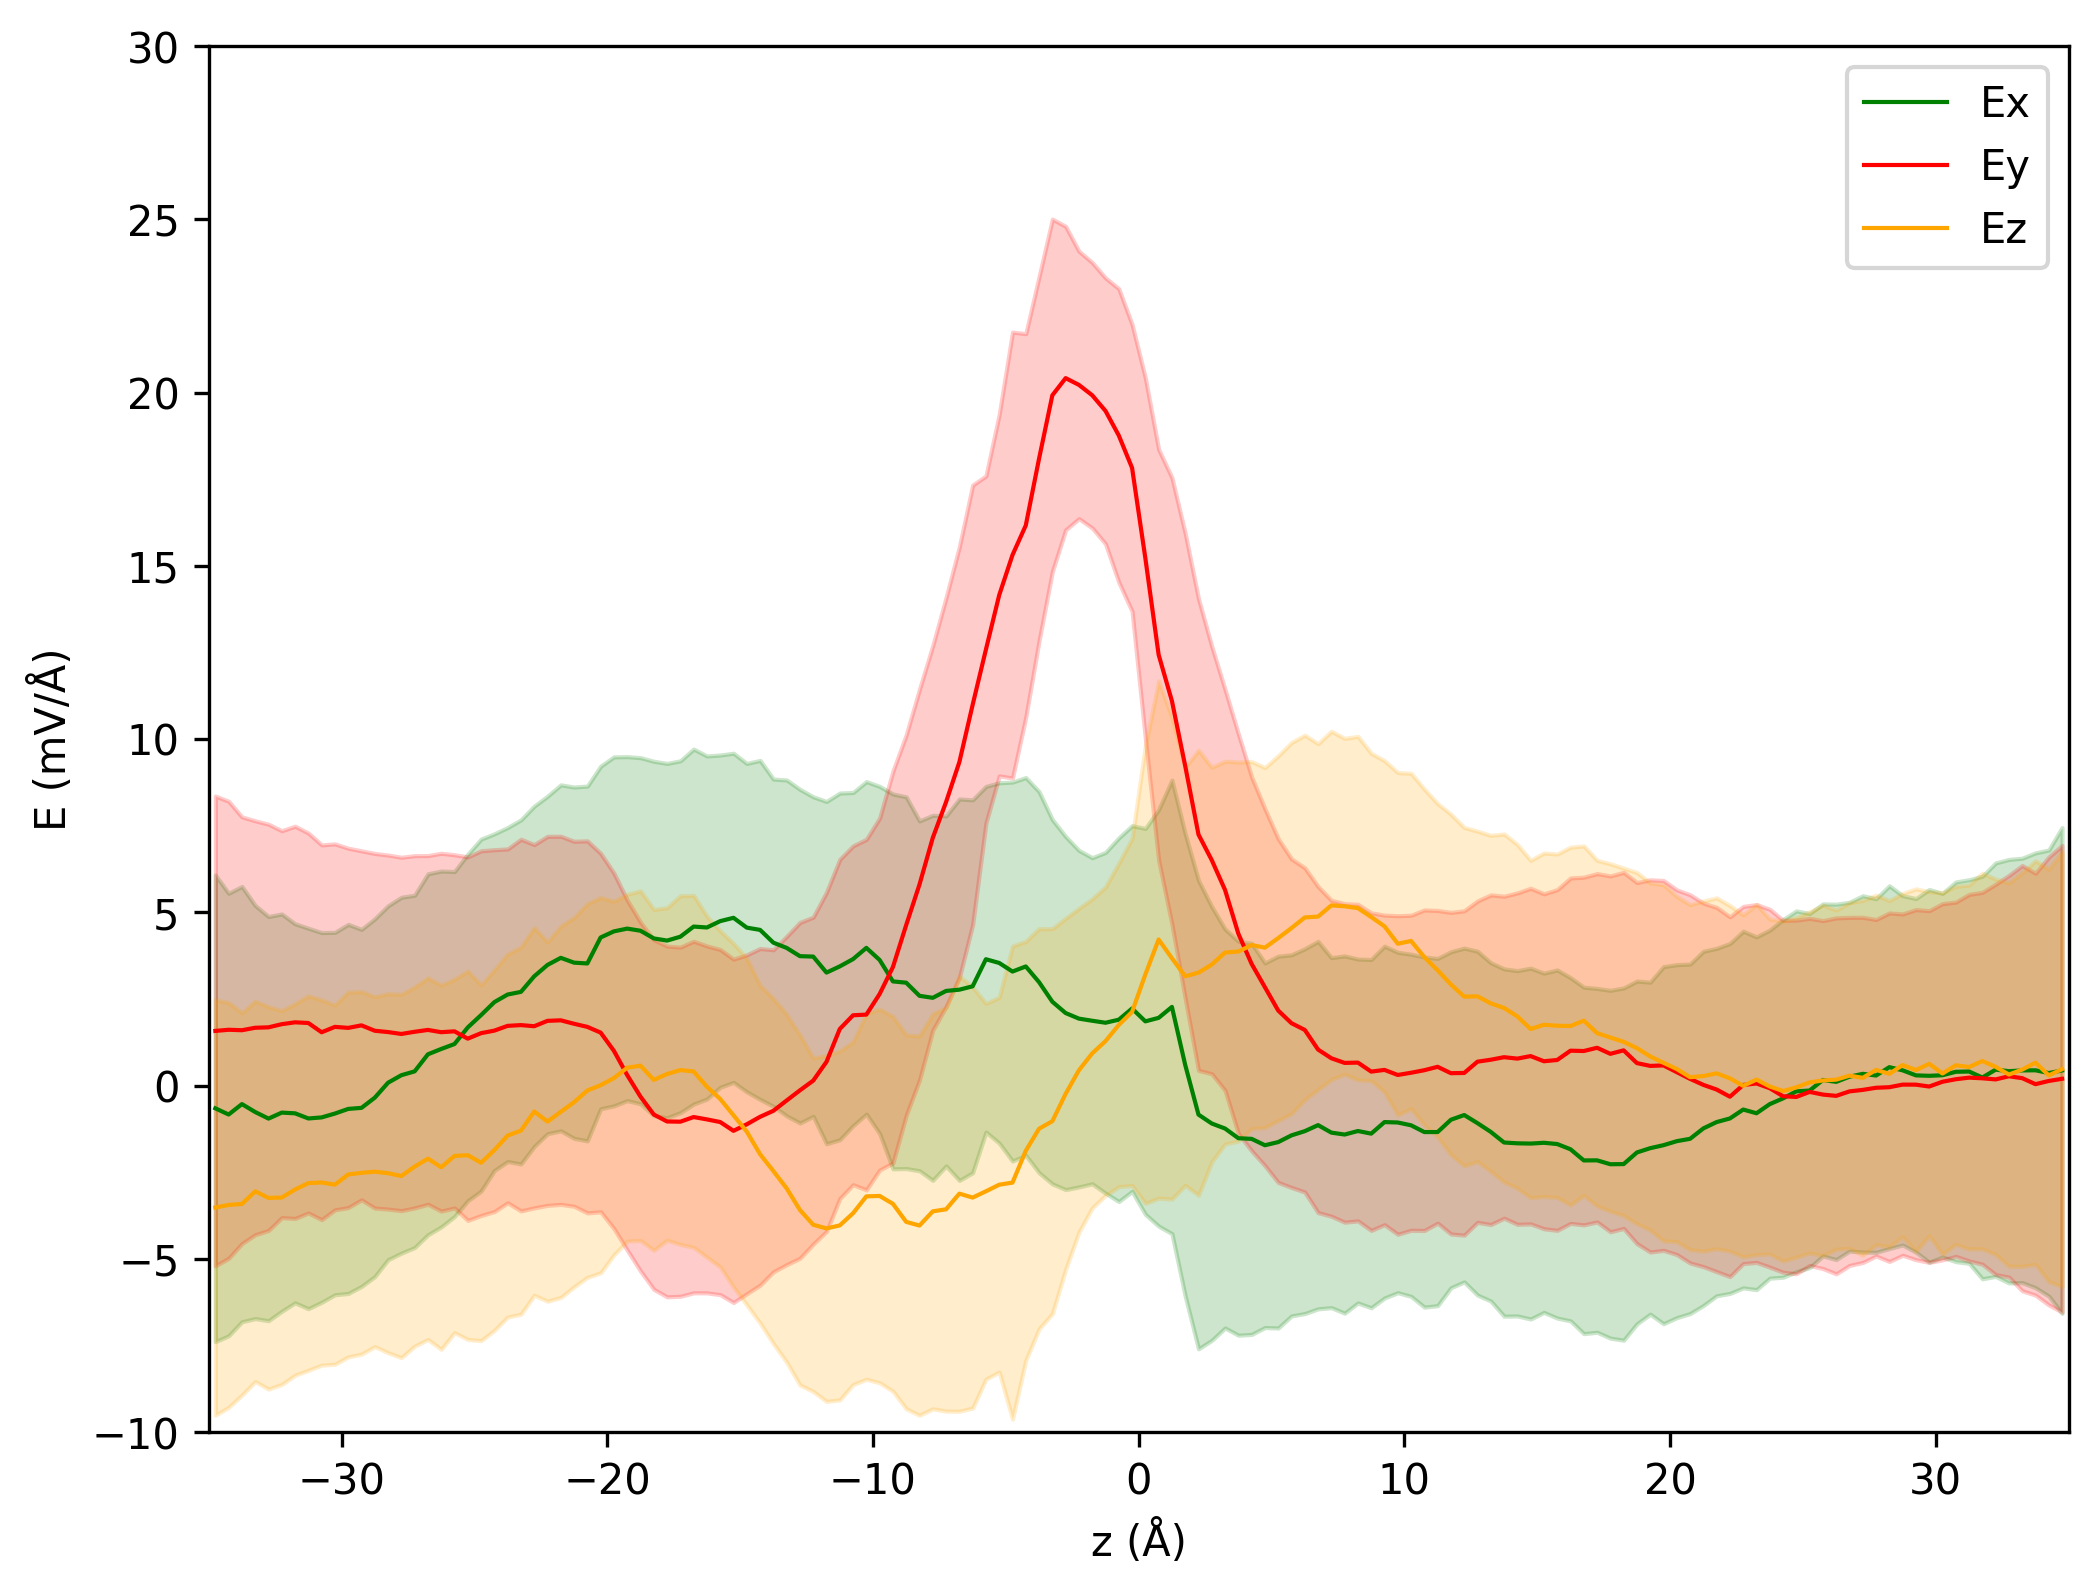

In [76]:
E_mean = np.vectorize(invert_Booth)(P_mean)
E_std = np.vectorize(invert_Booth)(P_std)

plt.figure(figsize=(8,6), dpi=300)
plt.plot(z, E_mean[:, 0], label='Ex', color='g', linewidth=1)
plt.fill_between(z, E_mean[:, 0] - E_std[:, 0], E_mean[:, 0] + E_std[:, 0], alpha=0.2, color='g')
plt.plot(z, E_mean[:, 1], label='Ey', color='r', linewidth=1)
plt.fill_between(z, E_mean[:, 1] - E_std[:, 1], E_mean[:, 1] + E_std[:, 1], alpha=0.2, color='r')
plt.plot(z, E_mean[:, 2], label='Ez', color='orange', linewidth=1)
plt.fill_between(z, E_mean[:, 2] - E_std[:, 2], E_mean[:, 2] + E_std[:, 2], alpha=0.2, color='orange')
plt.ylim(-10, 30)
plt.xlim(-35, 35)
plt.xlabel('z (Å)')
plt.ylabel('E (mV/Å)')
plt.legend()
plt.show()